* https://www.kaggle.com/aleksandradeis/globalwheatdetection-eda

* https://www.kaggle.com/shonenkov/training-efficientdet

In [1]:
import os
import cv2
import re
import random
import numpy as np
import pandas as pd

# For Visualization
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# For Image Augmentation
import albumentations as A
from PIL import Image,ImageDraw
from ast import literal_eval

# For parallel processing
from joblib import Parallel,delayed

# For Object Detection
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
def load_model(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    model.eval()
    
    return model

In [3]:
os.chdir('/kaggle/input/global-wheat-detection')
os.listdir()

['train', 'sample_submission.csv', 'train.csv', 'test']

In [4]:
test=os.listdir('test')

In [5]:
train=pd.read_csv('train.csv')

In [6]:
train.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [7]:
train['x_min']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[0])[0]))
train['y_min']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[1])[0]))
train['box_width']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[2])[0]))
train['box_height']=train['bbox'].apply(lambda x:float(re.findall(r'[0-9.]+',x.split(',')[3])[0]))

In [8]:
train.drop('bbox',axis=1,inplace=True)

In [9]:
train['box_area']=train['box_width']*train['box_height']
train['x_max']=train['x_min']+train['box_width']
train['y_max']=train['y_min']+train['box_height']

In [10]:
print(f'No of Unique Images are {train.image_id.nunique()}')

No of Unique Images are 3373


# Visualizing Images

In [11]:
def show_images(df,rows,cols,title,linecolor):
    """ Function to show images with detected objects"""
    fig, axs = plt.subplots(rows, cols, figsize=(10,10))
    
    for row in range(rows):
        for col in range(cols):
            idx = np.random.randint(len(df), size=1)[0]
            images=df.iloc[idx].image_id

            path=os.path.join('train',images+'.jpg')
            image=Image.open(path)

            objects=train[train['image_id']==images][['x_min','x_max','y_min','y_max']].values
            # Drawing on the Image
            draw=ImageDraw.Draw(image)

            for box in objects:
                draw.rectangle([box[0],box[2],box[1],box[3]],width=10,outline=linecolor)
            plt.figure(figsize=(10,10))
            axs[row,col].imshow(image)
            axs[row,col].axis('off')
    plt.suptitle(title)

In [12]:
# No of Bounding Boxes per Image
train['count']=train.apply(lambda row: 1 if np.isfinite(row.width) else 0, axis=1)
train_images_spikes= train.groupby('image_id')['count'].sum().reset_index()

In [13]:
# Visualizing Spikes
counts,bins=np.histogram(train_images_spikes['count'],bins=range(0,117,4))
labels=[]
for i in range(0,len(bins)-1):
    labels.append(f'({bins[i]}-{bins[i+1]}]')
px.bar(x=labels,y=counts,labels={'x':'Range of Wheats per Images','y':'count'},title="Number of wheat spikes per image")

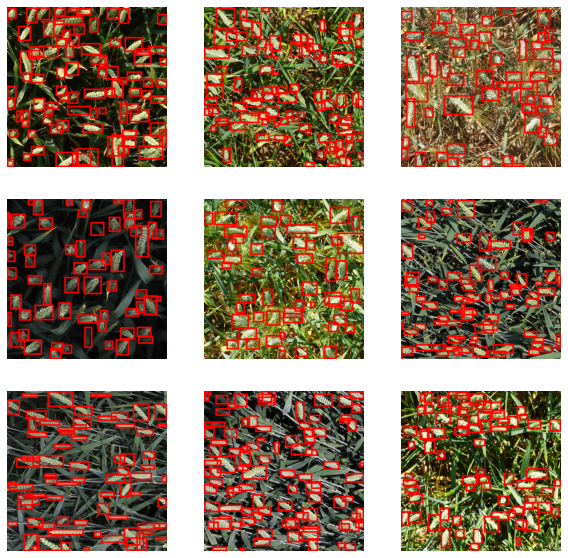

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [14]:
# Visualizing Images with Higher spikes
show_images(train_images_spikes[train_images_spikes['count']>50],3,3,'Images with Higher Spikes','red')

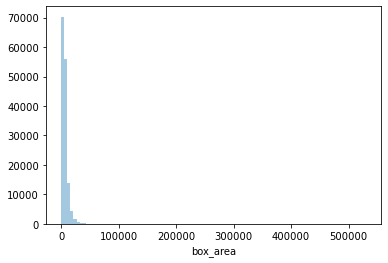

In [15]:
sns.distplot(train['box_area'],kde=False,bins=100)

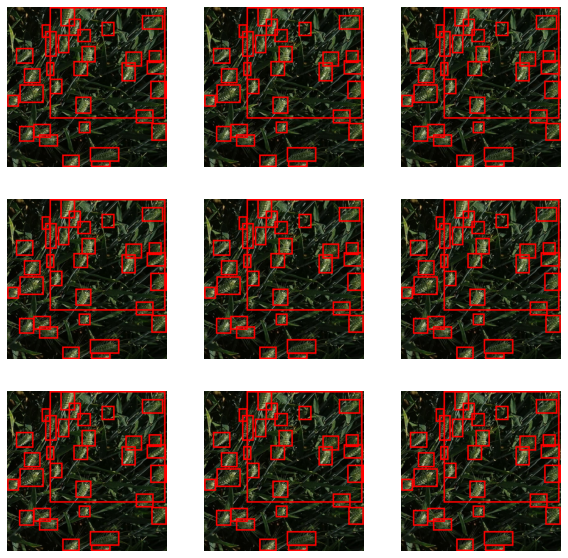

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [16]:
show_images(train[train['box_area']>500000],3,3,'Images with large bounding box','red')

 So we need to delete boxes with large areas

In [17]:
image_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                            [0.229,0.224,0.225])
])

In [18]:
# Spliting the dataset
train_set,val_set=train_test_split(train,test_size=0.15,random_state=1)

In [19]:
class DatasetGenerator(Dataset):
    
    def __init__(self,dataset,transforms=None,test=False):
        super().__init__()
        self.dataset=dataset # Train dataset which contains boxes
        self.transforms=transforms # Image Transformation
        self.test=test # Test set
    
    def __getitem__(self,index):
        image_id = self.dataset.iloc[index]['image_id']
        img_path=os.path.join(f'train/{image_id}.jpg')
        img=Image.open(img_path)
        
        # Convert everything into a torch tensor
        boxes=torch.tensor(self.dataset[self.dataset['image_id']==image_id]
                           [['x_min','y_min','x_max','y_max']].values,dtype=torch.float32)
        
        # Classes
        labels=torch.ones((boxes.shape[0]),dtype=torch.int64)
        iscrowd=torch.zeros((boxes.shape[0],), dtype=torch.int64)        
        target={}
        
        target['boxes']=boxes
        target['labels']=labels
        target['image_id']=torch.tensor([index])
        target['area']=torch.tensor(self.dataset[self.dataset['image_id']==image_id]['box_area'].values,
                                    dtype=torch.float32)
        target['iscrowd']=iscrowd
        
        if self.transforms is not None:
            img=self.transforms(img)
        return img,target
    
    def __len__(self):
        return self.dataset['image_id'].nunique()

In [20]:
train_dataset = DatasetGenerator(
    dataset=train_set,
    transforms=image_transforms,
    test=False,
)

validation_dataset = DatasetGenerator(
    dataset=val_set,
    transforms=image_transforms,
    test=True,
)

In [21]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader=DataLoader(train_dataset,batch_size=4,shuffle=False,num_workers=4,collate_fn=collate_fn)
test_loader=DataLoader(validation_dataset,batch_size=4,shuffle=False,num_workers=4,collate_fn=collate_fn)

# Loading Pretrained FasterRCNN Model

In [22]:
DEVICE=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_EPOCHS=1
LR=0.005

In [23]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (Wheat spikes) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


# Train

In [24]:
model=model.to(DEVICE)

In [25]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [26]:
train_loss=0
val_loss=0
epochs=list(range(NUM_EPOCHS))

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LR,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [27]:
loss_hist = Averager()
itr = 1

for epoch in range(NUM_EPOCHS):
    loss_hist.reset()
    
    for images, targets in train_loader:
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        del images,targets

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}") 


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning:

The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 

/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)



Iteration #50 loss: 0.8705596327781677
Iteration #100 loss: 0.8806900978088379
Iteration #150 loss: 0.8190189599990845
Iteration #200 loss: 0.7807420492172241
Iteration #250 loss: 0.8914769887924194
Iteration #300 loss: 0.754490077495575
Iteration #350 loss: 0.6441417932510376
Iteration #400 loss: 0.7582212090492249
Iteration #450 loss: 0.9635115265846252
Iteration #500 loss: 0.7407868504524231
Iteration #550 loss: 0.7604860067367554
Iteration #600 loss: 0.7229334115982056
Iteration #650 loss: 0.6678649187088013
Iteration #700 loss: 0.6918961405754089
Iteration #750 loss: 0.6262080669403076
Iteration #800 loss: 0.5324663519859314
Epoch #0 loss: 0.7775244899491822


In [28]:
os.chdir('/kaggle/working')

In [29]:
checkpoint={'model':model,
           'state_dict':model.state_dict()}


torch.save(checkpoint, 'fasterrcnn_resnet50_fpn.pth')

In [30]:
"""model=load_model('fasterrcnn_resnet50_fpn.pth')

model=model.to(DEVICE)

box=[]
with torch.no_grad():
    for img_name in test:
        img_path=os.path.join(f'test/{img_name}')
        img=Image.open(img_path)

        img=image_transforms(img)
        img=img.unsqueeze(0)

        img=img.to(DEVICE)

        output=model(img)
        output=output[0]['boxes'].cpu().detach().flatten().tolist()
        boxes=''
        for i in output:
            boxes=boxes+str(i)+' '
        box.append(boxes)
        del img,boxes,output,img_path

prediction=pd.DataFrame({'image_id':test,'PredictionString':box})

os.chdir('/kaggle/working')

#prediction.to_csv('submission.csv',index=False)"""

"model=load_model('fasterrcnn_resnet50_fpn.pth')\n\nmodel=model.to(DEVICE)\n\nbox=[]\nwith torch.no_grad():\n    for img_name in test:\n        img_path=os.path.join(f'test/{img_name}')\n        img=Image.open(img_path)\n\n        img=image_transforms(img)\n        img=img.unsqueeze(0)\n\n        img=img.to(DEVICE)\n\n        output=model(img)\n        output=output[0]['boxes'].cpu().detach().flatten().tolist()\n        boxes=''\n        for i in output:\n            boxes=boxes+str(i)+' '\n        box.append(boxes)\n        del img,boxes,output,img_path\n\nprediction=pd.DataFrame({'image_id':test,'PredictionString':box})\n\nos.chdir('/kaggle/working')\n\n#prediction.to_csv('submission.csv',index=False)"